In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
from datetime import datetime

In [2]:
#Inputs of the desired data if don't want to change it manually 
input_tickers = ['AKE.PA']
main_ticker = ['AKE.PA'] 
start_date_input = '2020-1-1'
index = '^MDAXI'
simulations = 20000
trading_days = 252
rf_rate = 0

In [3]:
#IMPORTING DATA FROM YAHOO FINANCE
def import_stock_data(tickers, start, end = datetime.today().strftime('%Y-%m-%d')):
    data = pd.DataFrame()
    if len([tickers]) ==1:
        data[tickers] = wb.DataReader(tickers, data_source='yahoo', start = start)['Adj Close']
        data = pd.DataFrame(data)
    else:
        for t in tickers:
            data[t] = wb.DataReader(t, data_source='yahoo', start = start)['Adj Close']
    return(data)

data = import_stock_data(tickers = main_ticker, start = start_date_input)


In [4]:
#CALCULATING LOG RETURNS 
def log_returns(data):
    return (np.log(1+data.pct_change()))
log_return = log_returns(data)

#CALCULATING SIMPLE RETURNS 
def simple_returns(data):
    return ((data/data.shift(1))-1)
    

In [5]:
#CAPM AND SHARPE
def market_data_combination(data, mark_ticker, start):
    market_data = import_stock_data(mark_ticker, start)
    market_rets = log_returns(market_data).dropna()
    ann_return = np.exp(market_rets.mean()*252).values-1
    data = data.merge(market_data, left_index=True, right_index=True)
    return data, ann_return


In [6]:
def beta_sharpe(data, mark_ticker = index, start=start_date_input, riskfree = rf_rate):
    
    """
    Input: 

    riskfree: the assumed risk free yield (US 10 Year Bond is assumed: 2.5%)
    
    Output:
    1. Dataframe with CAPM metrics computed against specified market procy
    """
    # Beta
    dd, mark_ret = market_data_combination(data, mark_ticker, start)
    log_ret = log_returns(dd)
    covar = log_ret.cov()*252
    covar = pd.DataFrame(covar.iloc[:-1,-1])
    mrk_var = log_ret.iloc[:,-1].var()*252
    beta = covar/mrk_var
    
    stdev_ret = pd.DataFrame(((log_ret.std()*252**0.5)[:-1]), columns=['STD'])

    beta = beta.merge(stdev_ret, left_index=True, right_index=True)
    
    # CAPM
    for i, row in beta.iterrows():
        beta.at[i,'CAPM'] = riskfree + (row[mark_ticker] * (mark_ret-riskfree))
    # Sharpe
    for i, row in beta.iterrows():
        beta.at[i,'Sharpe'] = ((row['CAPM']-riskfree)/(row['STD']))
    beta.rename(columns={index:"Beta"}, inplace=True)
    
    return beta

capm_sharpe = pd.DataFrame(data = beta_sharpe(data))


In [7]:
#Browinan Motion
def drift_calc(data, return_type='log'):
    if return_type=='log':
        lr = log_returns(data)
    elif return_type=='simple':
        lr = simple_returns(data)
    u = lr.mean()
    var = lr.var()
    drift = u-(0.5*var)
    try:
        return drift.values
    except:
        return drift
drift_calc(data)


array([0.00047407])

In [8]:
#Monte Carlo Returns 
def daily_returns(data, days, iterations, return_type='log'):
    ft = drift_calc(data, return_type)
    if return_type == 'log':
        try:
            stv = log_returns(data).std().values
        except:
            stv = log_returns(data).std()
    elif return_type=='simple':
        try:
            stv = simple_returns(data).std().values
        except:
            stv = simple_returns(data).std()    
    #Oftentimes, we find that the distribution of returns is a variation of the normal distribution where it has a fat tail
    # This distribution is called cauchy distribution
    dr = np.exp(ft + stv * norm.ppf(np.random.rand(days, iterations)))
    return dr
dr = daily_returns(data, 2, 3)


/Users/leftstories/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/leftstories/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


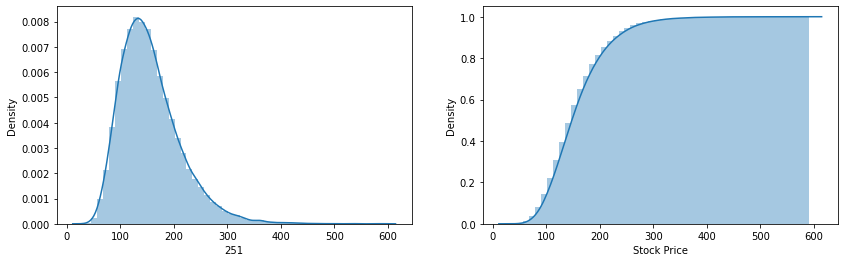

AKE.PA
Days: 251
Expected Value: $156.31
Return: 16.26%
Probability of Breakeven: 0.63415


,0,1,2,3,4,5,6,7,8,9,...,19990,19991,19992,19993,19994,19995,19996,19997,19998,19999
0,130.899994,130.899994,130.899994,130.899994,130.899994,130.899994,130.899994,130.899994,130.899994,130.899994,...,130.899994,130.899994,130.899994,130.899994,130.899994,130.899994,130.899994,130.899994,130.899994,130.899994
1,134.318696,139.320490,127.498369,132.495084,132.806959,129.932854,127.461310,133.571302,126.127037,131.044187,...,124.970091,137.919168,133.167512,132.920924,133.939728,138.165200,132.876882,131.711220,131.226871,129.619176
2,131.347379,135.352903,132.218942,133.005606,140.590833,123.658821,130.635092,132.863274,123.257344,127.669783,...,120.032774,142.218798,131.088873,131.099539,134.189746,138.953105,131.068468,135.625959,132.983278,130.849947
3,131.151780,135.896186,131.369512,133.651128,143.889215,121.615447,132.021510,128.570018,120.398486,121.861559,...,121.906613,140.786614,129.226141,129.071836,134.041444,134.395154,126.985515,136.838111,132.358207,133.407239
4,132.503139,135.982337,132.402242,137.110399,140.209731,122.502628,130.981486,130.568826,120.742012,118.766911,...,121.775946,138.694253,126.908895,131.919711,135.558079,134.025955,125.722287,141.251819,134.870665,133.334064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,114.390888,148.406671,156.989137,132.492665,243.722725,200.345887,135.724371,146.659715,125.500986,166.065887,...,182.169224,167.338290,137.362233,116.903421,125.558346,129.873240,74.116844,163.001686,228.867442,92.518693
248,114.774449,144.196813,158.843692,136.418462,246.428373,196.727790,140.473752,140.166457,123.009771,166.909504,...,178.554111,171.463883,134.448980,117.448274,128.573424,128.423822,74.429293,157.133780,228.321593,90.052770
249,117.115286,149.896629,158.388791,133.212507,246.938136,202.295081,141.710648,137.564697,127.423951,170.185494,...,180.754828,172.104594,134.312322,119.572263,126.342189,128.680203,72.262533,159.601065,227.343582,89.476560
250,121.363254,147.836591,157.223515,133.241928,249.215970,209.215153,141.405465,139.132660,123.812871,173.174620,...,181.412999,172.691779,132.833950,120.111339,126.945981,125.490050,73.473331,162.313003,229.488371,89.538119


In [9]:
def probs_find(predicted, higherthan, on = 'value'):
    """
    This function calculated the probability of a stock being above a certain threshhold, which can be defined as a value (final stock price) or return rate (percentage change)
    Input: 
    1. predicted: dataframe with all the predicted prices (days and simulations)
    2. higherthan: specified threshhold to which compute the probability (ex. 0 on return will compute the probability of at least breakeven)
    3. on: 'return' or 'value', the return of the stock or the final value of stock for every simulation over the time specified
    """
    if on == 'return':
        predicted0 = predicted.iloc[0,0]
        predicted = predicted.iloc[-1]
        predList = list(predicted)
        over = [(i*100)/predicted0 for i in predList if ((i-predicted0)*100)/predicted0 >= higherthan]
        less = [(i*100)/predicted0 for i in predList if ((i-predicted0)*100)/predicted0 < higherthan]
    elif on == 'value':
        predicted = predicted.iloc[-1]
        predList = list(predicted)
        over = [i for i in predList if i >= higherthan]
        less = [i for i in predList if i < higherthan]
    else:
        print("'on' must be either value or return")
    return (len(over)/(len(over)+len(less)))

def simulate_mc(data, days, iterations, return_type='log', plot=True):
    # Generate daily returns
    returns = daily_returns(data, days, iterations, return_type)
    # Create empty matrix
    price_list = np.zeros_like(returns)
    # Put the last actual price in the first row of matrix. 
    price_list[0] = data.iloc[-1]
    # Calculate the price of each day
    for t in range(1,days):
        price_list[t] = price_list[t-1]*returns[t]
    
    # Plot Option
    if plot == True:
        x = pd.DataFrame(price_list).iloc[-1]
        fig, ax = plt.subplots(1,2, figsize=(14,4))
        sns.distplot(x, ax=ax[0])
        sns.distplot(x, hist_kws={'cumulative':True},kde_kws={'cumulative':True},ax=ax[1])
        plt.xlabel("Stock Price")
        plt.show()
    
    #CAPM and Sharpe Ratio
    
    # Printing information about stock
    try:
        [print(nam) for nam in data.columns]
    except:
        print(data.name)
    print(f"Days: {days-1}")
    print(f"Expected Value: ${round(pd.DataFrame(price_list).iloc[-1].mean(),2)}")
    print(f"Return: {round(100*(pd.DataFrame(price_list).iloc[-1].mean()-price_list[0,1])/pd.DataFrame(price_list).iloc[-1].mean(),2)}%")
    print(f"Probability of Breakeven: {probs_find(pd.DataFrame(price_list),0, on='return')}")
   
          
    return pd.DataFrame(price_list)
simulate_mc(data, days = trading_days, iterations = simulations, return_type = 'log')


/Users/leftstories/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/leftstories/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


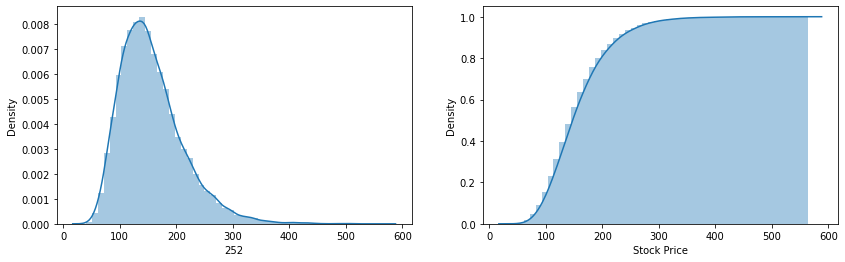

AKE.PA
Days: 252
Expected Value: $156.27
Return: 16.23%
Probability of Breakeven: 0.6325
            Beta       STD      CAPM    Sharpe
AKE.PA  1.099314  0.349833  0.092548  0.264549
Beta: 1.1
Sharpe: 0.26
CAPM Return: 9.25%


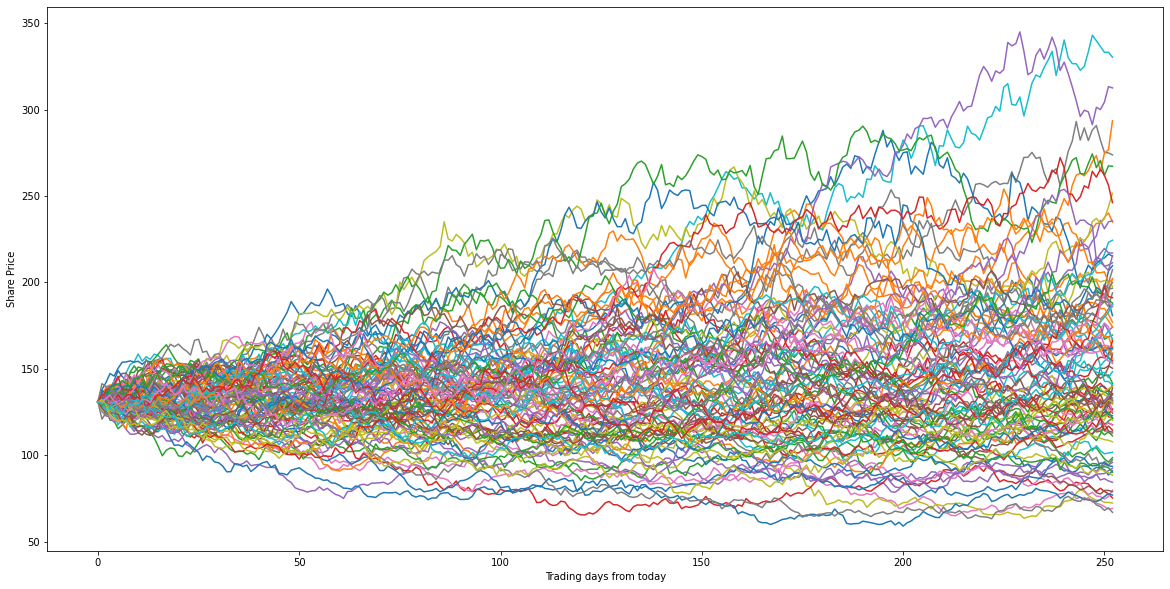

In [10]:
def monte_carlo(tickers, days_forecast, iterations, start_date, return_type = 'log', plotten=True):
    data = import_stock_data(input_tickers, start=start_date_input)
    inform = beta_sharpe(data, mark_ticker=index, start=start_date_input)
    simulatedDF = []
    for t in range(len(tickers)):
        y = simulate_mc(data.iloc[:,t], (days_forecast+1), iterations, return_type)
        if plotten == True:
            forplot = y.iloc[:,0:100]
            forplot.plot(figsize=(20,10), legend = None, xlabel = 'Trading days from today', ylabel = 'Share Price')
        print(inform)
        print(f"Beta: {round(inform.iloc[t,inform.columns.get_loc('Beta')],2)}")
        print(f"Sharpe: {round(inform.iloc[t,inform.columns.get_loc('Sharpe')],2)}") 
        print(f"CAPM Return: {round(100*inform.iloc[t,inform.columns.get_loc('CAPM')],2)}%")
        
        y['ticker'] = tickers[t]
        cols = y.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        y = y[cols]
        simulatedDF.append(y)
        simulatedDF = pd.concat(simulatedDF)
    return simulatedDF


ret_sim_df = monte_carlo(input_tickers, days_forecast= trading_days, iterations=simulations,  start_date=start_date_input, plotten=True)

